In [1]:
import pandas as pd
#import psycopg2 as pg

import fiona
import geopandas as gpd

import folium
import numpy as np
import matplotlib.pyplot as plt

import requests
import json

In [3]:
import os
os.chdir('..')

#### Reading in shapefile

In [260]:

dept_gdf = gpd.read_file('data/geom/gadm36_SEN_2.shp')
# Dept name in gdf to lower case
dept_gdf['NAME_2'] = dept_gdf['NAME_2'].str.lower()

dept_gdf.head()

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,SEN,Senegal,SEN.1_1,Dakar,None,SEN.1.1_1,dakar,None,None,Département,Department,11,SN.DK.DK,"MULTIPOLYGON (((-17.46736 14.65097, -17.46736 ..."
1,SEN,Senegal,SEN.1_1,Dakar,None,SEN.1.2_1,guédiawaye,None,None,Département,Department,14,SN.DK.GD,"POLYGON ((-17.40012 14.75731, -17.40051 14.757..."
2,SEN,Senegal,SEN.1_1,Dakar,None,SEN.1.3_1,pikine,None,None,Département,Department,12,SN.DK.PK,"POLYGON ((-17.39897 14.73781, -17.39903 14.737..."
3,SEN,Senegal,SEN.1_1,Dakar,None,SEN.1.4_1,rufisque,Rufisque-Bargny,None,Département,Department,13,SN.DK.RF,"POLYGON ((-17.16949 14.63201, -17.16952 14.632..."
4,SEN,Senegal,SEN.2_1,Diourbel,None,SEN.2.1_1,bambey,None,None,Département,Department,31,SN.DB.BB,"POLYGON ((-16.37093 14.60763, -16.37140 14.607..."


### Yield Data

In [7]:
# installing engine to read xlsx in pandas
!pip install openpyxl

In [137]:
dept_yield_df = pd.read_excel('data/Agriculture_yield_area_production_Senegal.xlsx',sheet_name='departments yields',engine='openpyxl')

dept_yield_df.head()

C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Region,Department,Year,Crop,Area planted (ha),Production (T),Yield (ton/ha),Total surface area department (ha),percentage of area planted in region for crop type,Exact locations?,data from http://www.maer.gouv.sn/focus/statistiques-cles/
0,DAKAR,Rufisque,2014/2015,Arachide,2943.0,589,0.200136,130000,2.263846,NaN,NaN
1,DAKAR,Rufisque,2015/2016,Arachide,1233.0,935,0.758313,130000,0.948462,NaN,NaN
2,DAKAR,Rufisque,2016/2017,Arachide,1248.0,257,0.205929,130000,0.960000,NaN,NaN
3,DAKAR,Rufisque,2014/2015,Cowpea,1178.0,177,0.150255,130000,0.906154,NaN,NaN
4,DAKAR,Rufisque,2015/2016,Cowpea,858.0,397,0.462704,130000,0.660000,NaN,NaN


In [139]:
dept_yield_df = dept_yield_df[dept_yield_df['Department'].notna()]
dept_yield_df.shape

(248, 11)

In [154]:
dept_yield_df['Year']=dept_yield_df['Year'].astype(str)

# Adjusting the year in the data for Rufisque Dept to the first value in col
# 2014/2015 -> 2014

dept_yield_df.loc[dept_yield_df['Year'].str.contains('/',regex=False),'Year'] = dept_yield_df[dept_yield_df['Year'].str.contains('/',regex=False)]['Year'].str.split(pat='/',expand=True)[0]
dept_yield_df.head(10)


,Region,Department,Year,Crop,Area planted (ha),Production (T),Yield (ton/ha),Total surface area department (ha),percentage of area planted in region for crop type,Exact locations?,data from http://www.maer.gouv.sn/focus/statistiques-cles/
0,DAKAR,Rufisque,2014,Arachide,2943.0,589,0.200136,130000,2.263846,NaN,NaN
1,DAKAR,Rufisque,2015,Arachide,1233.0,935,0.758313,130000,0.948462,NaN,NaN
2,DAKAR,Rufisque,2016,Arachide,1248.0,257,0.205929,130000,0.960000,NaN,NaN
3,DAKAR,Rufisque,2014,Cowpea,1178.0,177,0.150255,130000,0.906154,NaN,NaN
4,DAKAR,Rufisque,2015,Cowpea,858.0,397,0.462704,130000,0.660000,NaN,NaN
5,DAKAR,Rufisque,2016,Cowpea,1248.0,366,0.293269,130000,0.960000,NaN,NaN
6,DAKAR,Rufisque,2014,Corn,900.0,585,0.650000,130000,0.692308,NaN,NaN
7,DAKAR,Rufisque,2015,Corn,900.0,799,0.887778,130000,0.692308,NaN,NaN
8,DAKAR,Rufisque,2016,Corn,990.0,836,0.844444,130000,0.761538,NaN,NaN
9,DAKAR,Rufisque,2014,Sorghum,200.0,90,0.450000,130000,0.153846,NaN,NaN


In [114]:
# Some crops don't grow in some areas or yield is not available.
# In order to show all areas in the map for all crops for visual consistency,
# a template dataframe is created that includes all areas, all crops and all years.

dept_list = dept_gdf['NAME_2'].unique()
dept_list = [item.lower() for item in dept_list]
year_list = ['2014','2015','2016']
crop_list = dept_yield_df['Crop'].unique()
dept_year_crop_list = list()
len_dyc = len(dept_list)*len(year_list)*len(crop_list)
i = 0

for d in dept_list:
    for c in crop_list:
        for y in year_list:
            dept_year_crop_list.append([d,c,y])

template_df = pd.DataFrame(dept_year_crop_list,columns=['temp_dept','temp_crop','temp_year'])
template_df.head(3)

,temp_dept,temp_crop,temp_year
0,dakar,Arachide,2014
1,dakar,Arachide,2015
2,dakar,Arachide,2016


In [155]:
# The template DF created above is filled with available data

dept_yield_df['Department'] = dept_yield_df['Department'].str.lower()

dept_yield_df_filled = template_df.merge(dept_yield_df,how='left',
                                left_on=['temp_dept','temp_crop','temp_year'],
                               right_on = ['Department','Crop','Year'])

print(dept_yield_df_filled.shape)

dept_yield_df_filled.head(5)
# Dept 'Dakar' does not have any agriculture. So all the data is NaN. 

(810, 14)


,temp_dept,temp_crop,temp_year,Region,Department,Year,Crop,Area planted (ha),Production (T),Yield (ton/ha),Total surface area department (ha),percentage of area planted in region for crop type,Exact locations?,data from http://www.maer.gouv.sn/focus/statistiques-cles/
0,dakar,Arachide,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dakar,Arachide,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dakar,Arachide,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dakar,Cowpea,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dakar,Cowpea,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
# Just making sure the data is filled correctly... checking for 'Rufisque'

dept_yield_df_filled[(dept_yield_df_filled['temp_dept']=='oussouye')&(dept_yield_df_filled['temp_crop']=='Rice')].head()

,temp_dept,temp_crop,temp_year,Region,Department,Year,Crop,Area planted (ha),Production (T),Yield (ton/ha),Total surface area department (ha),percentage of area planted in region for crop type,Exact locations?,data from http://www.maer.gouv.sn/focus/statistiques-cles/
789,oussouye,Rice,2014,ZIGUINCHOR,oussouye,2014,Rice,4309.0,6818,1.58227,89100,4.836139,NaN,NaN
790,oussouye,Rice,2015,ZIGUINCHOR,oussouye,2015,Rice,14500.0,26999,1.86200,89100,16.273850,NaN,NaN
791,oussouye,Rice,2016,ZIGUINCHOR,oussouye,2016,Rice,14500.0,24650,1.70000,89100,16.273850,NaN,NaN


### Merging Yield & GDF / Shapefile

In [335]:
# Merging geoDF of depts with filled template 

dept_yield_gdf=dept_gdf.merge(dept_yield_df_filled,left_on='NAME_2',right_on='temp_dept',how='outer')
dept_yield_gdf.head()

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,...,Department,Year,Crop,Area planted (ha),Production (T),Yield (ton/ha),Total surface area department (ha),percentage of area planted in region for crop type,Exact locations?,data from http://www.maer.gouv.sn/focus/statistiques-cles/
0,SEN,Senegal,SEN.1_1,Dakar,None,SEN.1.1_1,dakar,None,None,Département,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SEN,Senegal,SEN.1_1,Dakar,None,SEN.1.1_1,dakar,None,None,Département,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SEN,Senegal,SEN.1_1,Dakar,None,SEN.1.1_1,dakar,None,None,Département,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SEN,Senegal,SEN.1_1,Dakar,None,SEN.1.1_1,dakar,None,None,Département,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SEN,Senegal,SEN.1_1,Dakar,None,SEN.1.1_1,dakar,None,None,Département,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plotting the Maps (choropleth) of yields

In [270]:
def plot_crop_map(year,crop):
    fig, ax = plt.subplots(1, 1)

    sample_gdf = dept_yield_gdf[(dept_yield_gdf['temp_year']==year) & (dept_yield_gdf['temp_crop']==crop)]
    #sample_gdf['Yield (ton/ha)'].fillna(0,inplace=True)
    
    sample_gdf.plot('Yield (ton/ha)',ax=ax,legend=True,missing_kwds={'color':'lightgrey'})
    

In [269]:
# function to plot multi-year yield data for given crop

def plot_crop_map_yrs(crop,year=year_list):
    
    if(type(year)==str):
        fig, ax = plt.subplots(1, 1)
        sample_gdf = dept_yield_gdf[(dept_yield_gdf['temp_year']==year) & (dept_yield_gdf['temp_crop']==crop)]
        sample_gdf.plot('Yield (ton/ha)',ax=ax,legend=True,missing_kwds={'color':'lightgrey'})
  
    elif(type(year)==list):
        fig, ax = plt.subplots(1, len(year),figsize=(15,10))
        max_yield = dept_yield_gdf[dept_yield_gdf['temp_crop']==crop]['Yield (ton/ha)'].max()
        
        for i in range(len(year)):
            sample_gdf = dept_yield_gdf[(dept_yield_gdf['temp_year']==year[i]) & (dept_yield_gdf['temp_crop']==crop)]
            sample_gdf.plot('Yield (ton/ha)',ax=ax[i],legend=True,
                            legend_kwds={'label':year[i],'orientation':'horizontal'},
                            missing_kwds={'color':'lightgrey'},
                           vmax=max_yield,vmin=0)
        
        

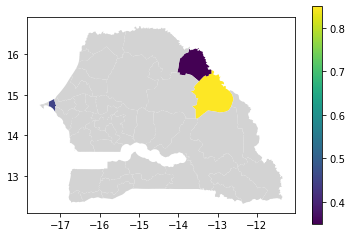

In [197]:
plot_crop_map('2014','Sorghum')

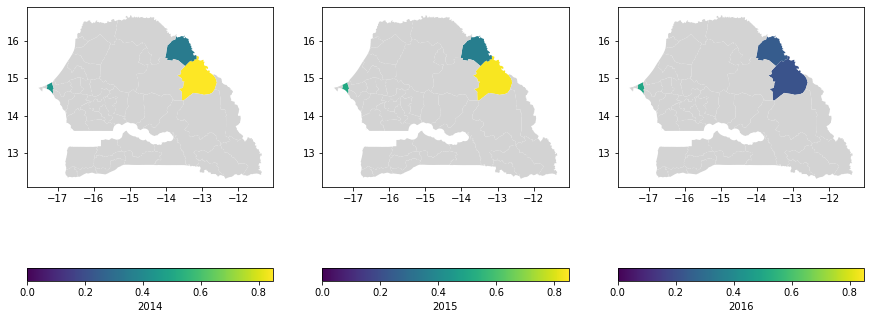

In [230]:
plot_crop_map_yrs('Sorghum')

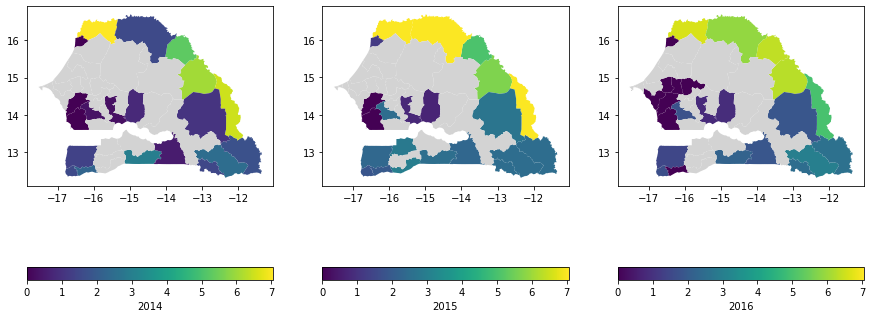

In [231]:
plot_crop_map_yrs('Rice')

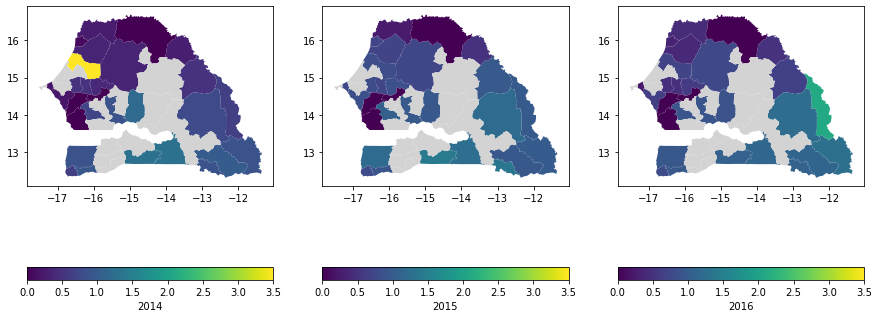

In [271]:
plot_crop_map_yrs('Arachide')

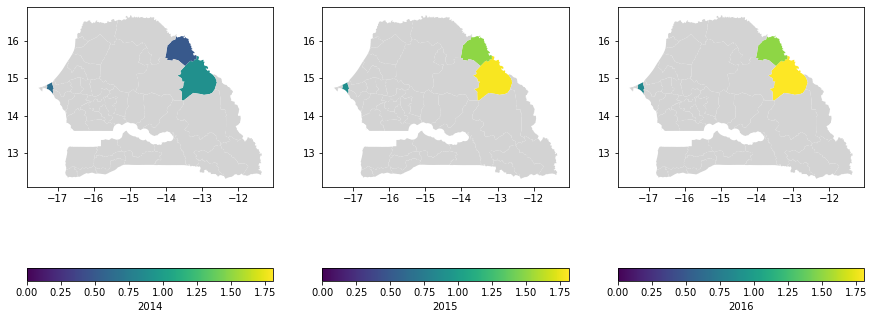

In [234]:
plot_crop_map_yrs('Corn')

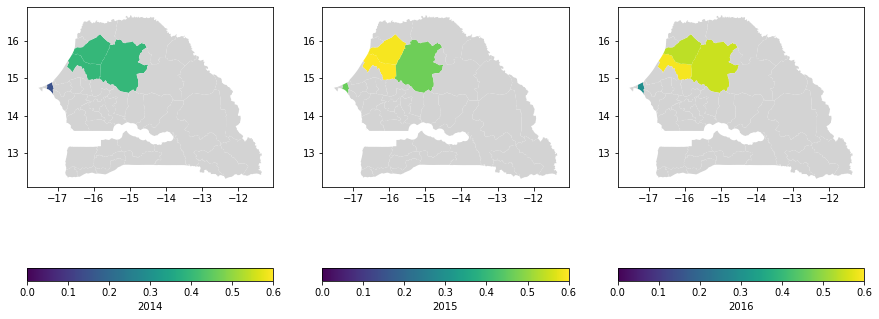

In [235]:
plot_crop_map_yrs('Cowpea')

### Plotting Crop Yield + Sowing time Average Precipitation

In [356]:
# function to plot for given crop
# - multi-year yield data
# - multi-year avg sow time precititation

def plot_crop_sowpr_map_yrs(crop,year=year_list):
    
    if(type(year)==str):
        fig, ax = plt.subplots(2, 1)
        
        sample_gdf = dept_yield_gdf[(dept_yield_gdf['temp_year']==year) & (dept_yield_gdf['temp_crop']==crop)]
        sample_gdf.plot('Yield (ton/ha)',ax=ax[1],legend=True,missing_kwds={'color':'lightgrey'})
        sample_gdf.plot('pr_sow',ax=ax[0],legend=True)#,missing_kwds={'color':'lightgrey'})
  
    elif(type(year)==list):
        fig, ax = plt.subplots(2, len(year),figsize=(15,10))
        max_yield = dept_yield_gdf[dept_yield_gdf['temp_crop']==crop]['Yield (ton/ha)'].max()
        max_pr = dept_yield_gdf[dept_yield_gdf['temp_crop']==crop]['pr_sow'].max()
        
        for i in range(len(year)):
            sample_gdf = dept_yield_gdf[(dept_yield_gdf['temp_year']==year[i]) & (dept_yield_gdf['temp_crop']==crop)]
            
            sample_gdf.plot('Yield (ton/ha)',ax=ax[0,i],legend=True,
                            legend_kwds={'label':year[i],'orientation':'horizontal'},
                            missing_kwds={'color':'lightgrey'},
                           vmax=max_yield,vmin=0)

            sample_gdf.plot('pr_sow',ax=ax[1,i],legend=True,
                            legend_kwds={'label':year[i],'orientation':'horizontal'},
                            #missing_kwds={'color':'lightgrey'},
                           vmax=max_pr,vmin=0)
            

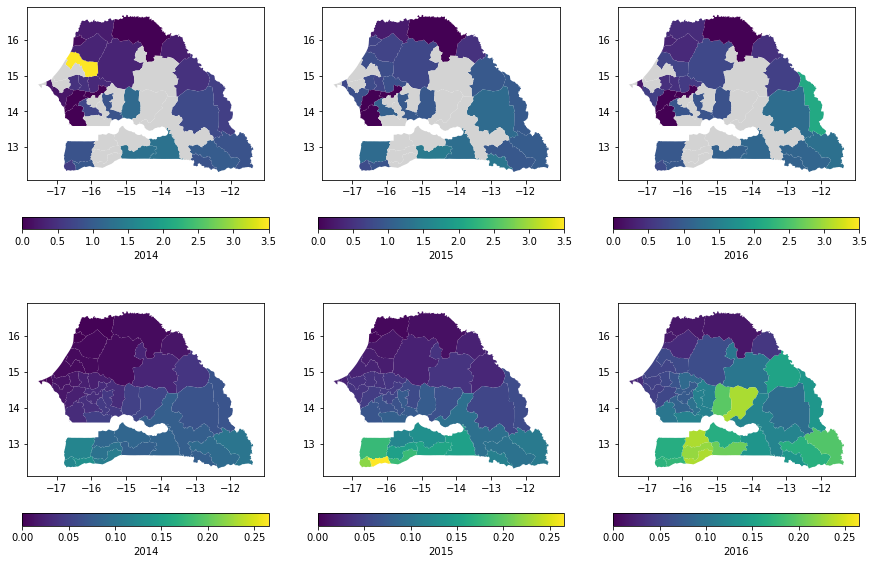

In [357]:
#plot_crop_sowpr_map_yrs('Arachide','2014')
plot_crop_sowpr_map_yrs('Arachide')

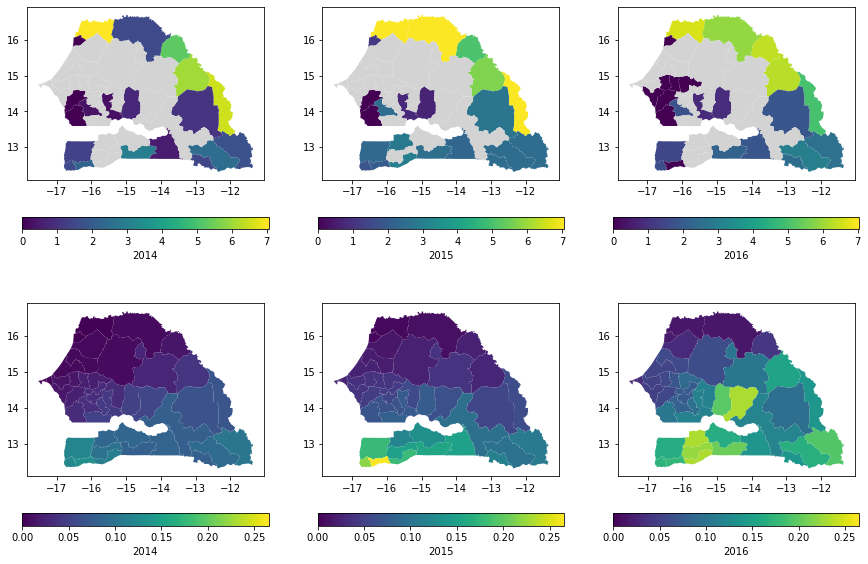

In [358]:
plot_crop_sowpr_map_yrs('Rice')

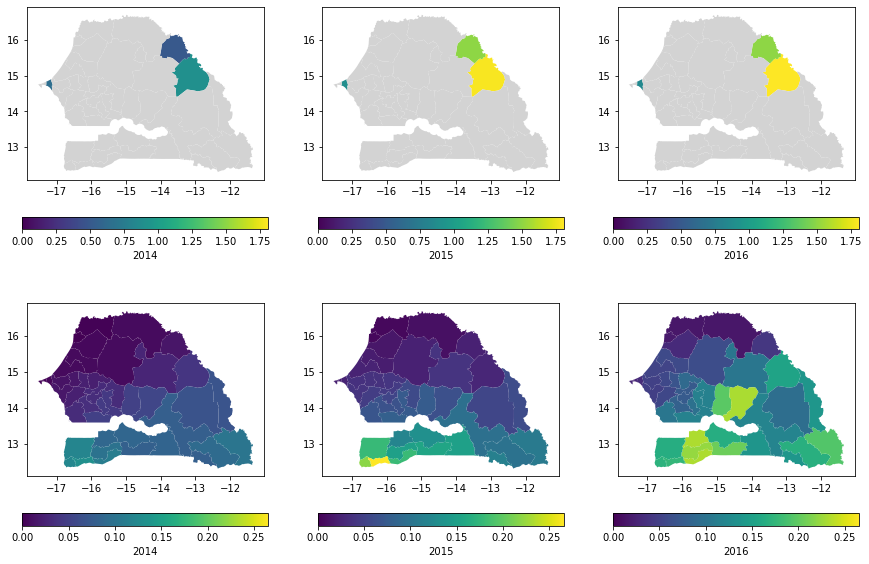

In [359]:
plot_crop_sowpr_map_yrs('Corn')

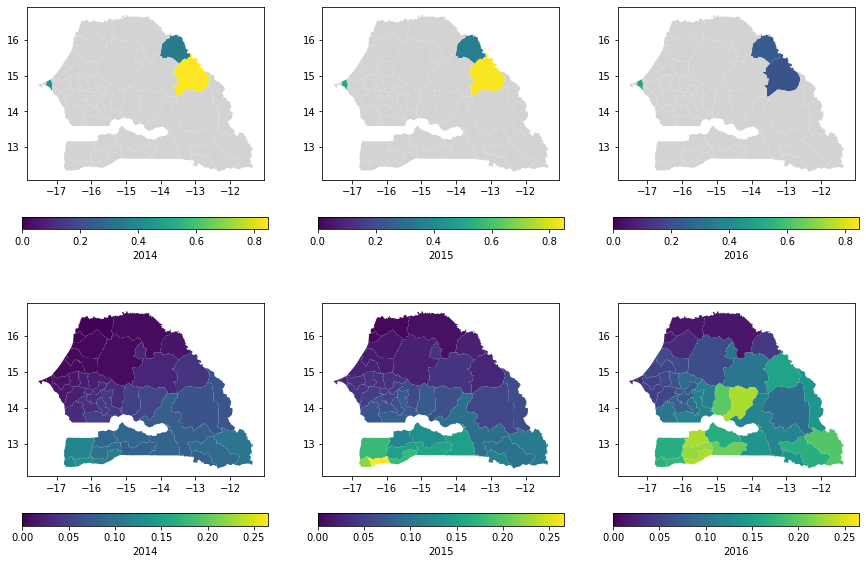

In [360]:
plot_crop_sowpr_map_yrs('Sorghum')

### Weather Data at department level

In [ ]:
# Getting location for each department

dept_gdf['geometry'][0].centroid.x


In [242]:
import requests
import json

In [321]:
## Using Jenny Chao's code for Oikos Weather API data extraction

# query weather data from oikolab API
def query_oikolab(location, start, end):
    indecies = ['temperature', 'total_precipitation', 'relative_humidity', 'wind_speed',
                'soil_temperature_level_1', 'soil_temperature_level_2', 
                'soil_temperature_level_3', 'soil_temperature_level_4']
    
    r = requests.get('https://api.oikolab.com/weather',
                     params={'param': indecies,
                             'start': start,
                             'end': end,
                             'lat': location[0],
                             'lon': location[1],
                             'freq': 'H',
                             'api-key': 'f805c3e156f64225b97eeae49ec78e92'}
                     )

    weather_data = json.loads(r.json()['data'])
    df = pd.DataFrame(data = weather_data['data'], columns = weather_data['columns'])
    df['year'] = pd.to_datetime(weather_data['index'], unit='s').year
    df['month'] = pd.to_datetime(weather_data['index'], unit='s').month
    df['day'] = pd.to_datetime(weather_data['index'], unit='s').day
    df['hour'] = pd.to_datetime(weather_data['index'], unit='s').hour
    
    return df

In [244]:
# rename columns and take monthly average of the weather indecies
def process_data(df, region):
    raw = df.rename(columns = {
        'temperature (degC)':'temp', 
        'total_precipitation (mm of water equivalent)':'pr',                          
        'relative_humidity (0-1)':'hum',                          
        'wind_speed (m/s)':'wind',                         
        'soil_temperature_level_1 (degC)':'soil_1',                          
        'soil_temperature_level_2 (degC)':'soil_2',                          
        'soil_temperature_level_3 (degC)':'soil_3',                          
        'soil_temperature_level_4 (degC)':'soil_4'                         
    })

    weather = []
    weather_indecies = ['temp', 'pr', 'hum', 'wind', 'soil_1', 'soil_2', 'soil_3', 'soil_4']
    
    for year in sorted(set(raw.year)):
        for month in sorted(set(raw.month)):
            monthly_weather = raw[(raw.year==year) & (raw.month==month)]
            
            # all day average statistics
            monthly_mean = monthly_weather.apply(np.mean)
            monthly_stat = [year, month, True, False, region] + monthly_mean[weather_indecies].to_list()
            weather.append(monthly_stat)
            
            # daytime average statistics
            monthly_mean = monthly_weather[monthly_weather.hour.between(8,18)].apply(np.mean)
            monthly_stat = [year, month, False, True, region] + monthly_mean[weather_indecies].to_list()
            weather.append(monthly_stat)
            
            # nighttime average statistics
            monthly_mean = monthly_weather[~monthly_weather.hour.between(6,20)].apply(np.mean)
            monthly_stat = [year, month, False, False, region] + monthly_mean[weather_indecies].to_list()
            weather.append(monthly_stat)
            
    weather = pd.DataFrame(weather, columns=['year', 'month', 'alltime', 'daytime', 'region',
                                             'temp', 'pr', 'hum', 'wind', 'soil_1', 'soil_2', 'soil_3', 'soil_4'])

    return weather

In [ ]:
# Per http://www.fao.org/giews/countrybrief/country.jsp?code=SEN&lang=es
# For most crops (rice, millets, groundnut, maize) , approx.
# sowing - June-July
# growing - Aug-Oct
# harvesting - Oct-Dec


In [341]:
sow_start = '06-01'
sow_end = '07-31'

# location = (dept_gdf['geometry'][0].centroid.y, dept_gdf['geometry'][0].centroid.x)
# dept = dept_gdf['temp_dept'][0]

for dept in dept_list:
    # Getting the weather data at the centroid of the region / department
    location = (dept_gdf[dept_gdf['NAME_2']==dept]['geometry'].centroid.y, 
                dept_gdf[dept_gdf['NAME_2']==dept]['geometry'].centroid.x)
    #print(location)
    for year in year_list:

        sow_start = year + '-' + sow_start
        sow_end = year + '-' + sow_end
        print(sow_start)
        dept_weather = process_data(query_oikolab(location, sow_start, sow_end), dept)

        pr_all_mask = (dept_weather['alltime']==True) & (dept_weather['region']==dept)
        for crop in crop_list:
            crop_year_mask = (dept_yield_gdf['temp_dept']==dept) & \
                                (dept_yield_gdf['temp_crop']==crop) & \
                                (dept_yield_gdf['temp_year']==year)
            dept_yield_gdf.loc[crop_year_mask,'pr_sow'] = dept_weather[pr_all_mask]['pr'].mean()

            #print(dept_yield_gdf[crop_year_mask]['pr_sow'])

        sow_start = '06-01'
        sow_end = '07-31'


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Anaconda3\envs\omdena-GPSDD\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


2014-06-01
2015-06-01
2016-06-01


In [247]:
dept_weather.head()

,year,month,alltime,daytime,region,temp,pr,hum,wind,soil_1,soil_2,soil_3,soil_4
0,2014,6,True,False,dakar,24.815764,0.000083,0.837611,4.088903,25.417889,25.270069,25.195542,25.053708
1,2014,6,False,True,dakar,25.330091,0.000000,0.808485,4.225364,25.721182,25.291909,25.231273,25.091212
2,2014,6,False,False,dakar,24.302259,0.000222,0.867926,4.012000,25.134519,25.248444,25.158815,25.015185
3,2014,7,True,False,dakar,26.424757,0.004743,0.803592,4.542178,27.528141,27.430929,27.350499,27.202288
4,2014,7,False,True,dakar,26.764939,0.001788,0.783364,4.547879,27.768909,27.429333,27.357970,27.210909


In [252]:

dept_weather[(dept_weather['alltime']==True) & (dept_weather['region']==dept_gdf['temp_dept'][0])]['pr'].sum()

0.004826745261211281